# Cluster Analysis of e-Scooter Accidents in London during 2018-2022

The cluster analysis of e-Scooter accidents in London from 2018 to 2022 aims to determine whether these accidents occur randomly or exhibit evidence of spatial clustering. To address this, various analytical processes are undertaken using global and local spatial autocorrelation. The initial method involves calculating spatial weights, comparing contiguity approaches (queen and rook), and employing K-Nearest Neighbors with k=8. Subsequently, spatial lag and Moran's I are computed. The second method incorporates local Moran's I and local indicators of spatial association (LISA) to provide a more comprehensive analysis of spatial patterns.

# Initial Steps

## Libraries to use

Several packages will be used in this spatial analysis:

- **Pandas (`pd`):** Utilized for reading and manipulating tabular data.
- **Geopandas (`gpd`):** Specialized for working with geospatial data, enabling the creation and manipulation of spatial data frames.
- **Contextily (`ctx`):** Employed for adding basemaps to spatial plots to provide context.
- **esda (Exploratory Spatial Data Analysis):** A component of PySAL, facilitating exploratory spatial data analysis, including Moran's I and local indicators of spatial association (LISA).
- **splot:** A PySAL library designed for visualizing spatial statistics.
- **libpysal (`lps`):** The core PySAL library for spatial analysis.
- **PySAL.weights:** Submodule used for generating spatial weight matrices (e.g., Queen, Rook) crucial for spatial analysis.
- **Matplotlib (`plt`):** A popular plotting library for creating static, interactive, and 3D visualizations.
- **Plotly Express (`px`):** Applied for interactive visualizations, especially beneficial for maps.
- **Matplotlib.patches (`mpatches`):** Provides functionality for creating and manipulating graphical patches (e.g., shapes,ical testing.

In [1]:
# Importing all necessary packages for this analysis
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# to show basemap
import contextily as ctx

# for spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation

import libpysal as lps
from libpysal.weights import Queen, Rook

# for graphics
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.patches as mpatches

## Data loading: GeoDataFrame

The geodataframe used in this analysis is London Ward that consists of 633 wards from 33 boroughs. The data is downloaded from London Datastore via https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip

Through this analysis, the mapping unit used is ward as geodataframe. In addition, borough geodataframe is also generated for visualisation purpose. The Coordinate Reference System (CRS) utilised for the calculation is metric, specifically EPSG 27700 - OSGB36 / British National Grid. However, visualisation of LISA result later should use Web Mercator CRS, specifically EPSG 3857.

In [2]:
# Loading the shapefile
london_ward = gpd.read_file('data/London_Ward_CityMerged.shp')

In [3]:
# Check the datatype
london_ward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        633 non-null    object  
 1   GSS_CODE    633 non-null    object  
 2   DISTRICT    633 non-null    object  
 3   LAGSSCODE   633 non-null    object  
 4   HECTARES    633 non-null    float64 
 5   NONLD_AREA  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


In [4]:
# Lowercase the column names
london_ward = london_ward.rename(columns=lambda x: x.lower())

# Then rename the column 'name' to 'ward'
london_ward.rename(columns={'name': 'ward', 'district': 'borough'}, inplace=True)

# Check the result
london_ward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ward        633 non-null    object  
 1   gss_code    633 non-null    object  
 2   borough     633 non-null    object  
 3   lagsscode   633 non-null    object  
 4   hectares    633 non-null    float64 
 5   nonld_area  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


In [5]:
# Inspect the table
london_ward

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.000,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.000,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.000,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.000,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.000,"POLYGON ((521201.203 169275.505, 521204.303 16..."
...,...,...,...,...,...,...,...
628,Whalebone,E05000042,Barking and Dagenham,E09000002,155.399,0.000,"POLYGON ((549410.698 187450.702, 549391.199 18..."
629,Eastbrook,E05000030,Barking and Dagenham,E09000002,345.060,0.000,"POLYGON ((549991.497 184928.504, 549988.899 18..."
630,Chadwell Heath,E05000029,Barking and Dagenham,E09000002,338.422,0.000,"POLYGON ((548874.200 188496.303, 548843.199 18..."
631,Parsloes,E05000037,Barking and Dagenham,E09000002,124.384,0.000,"POLYGON ((547381.597 185753.598, 547377.499 18..."


In [6]:
# Check the current CRS
print(london_ward.crs)

EPSG:27700


### Dissolve to London borough

London borough is only used for visualisation.

In [7]:
# Do dissolve to generate London borough gdf
london_borough = london_ward.dissolve(by='lagsscode', as_index=False)

# Delete columns of ward and gss_code
london_borough = london_borough.drop(columns=['ward', 'gss_code'])

# Show the result
london_borough

,lagsscode,geometry,borough,hectares,nonld_area
0,E09000001,"POLYGON ((531361.303 180690.997, 531313.201 18...",City and County of the City of London,314.943,24.546
1,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",Barking and Dagenham,113.874,4.906
2,E09000003,"POLYGON ((523293.197 186457.696, 523239.200 18...",Barnet,455.053,0.000
3,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",Bexley,188.689,0.000
4,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",Brent,267.991,0.000
5,E09000006,"POLYGON ((540344.998 157603.096, 540339.803 15...",Bromley,2903.960,0.000
6,E09000007,"POLYGON ((527578.700 183595.996, 527478.003 18...",Camden,125.671,0.000
7,E09000008,"POLYGON ((532849.503 157330.104, 532867.502 15...",Croydon,452.138,0.000
8,E09000009,"POLYGON ((510854.302 179385.201, 510880.002 17...",Ealing,379.609,0.000
9,E09000010,"POLYGON ((532296.400 191733.696, 532294.702 19...",Enfield,1693.541,0.000


In [8]:
# Check the CRS
print(london_borough.crs)

EPSG:27700


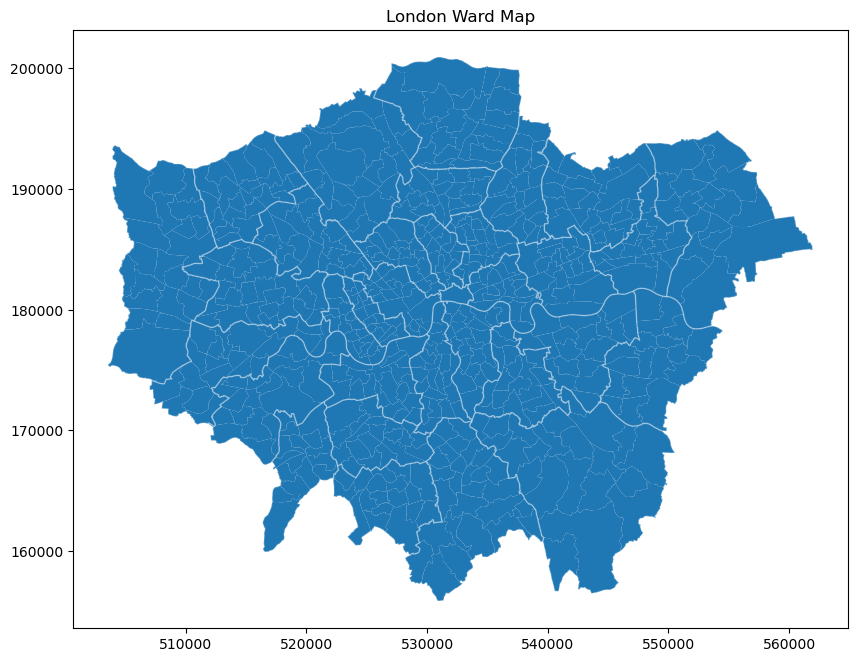

In [9]:
# Show the shapefile
fig, ax = plt.subplots(figsize=(10, 10))

# Plot london borough
london_borough.boundary.plot(ax=ax, color="white", linewidth=1, alpha=0.25)

# Plot London ward
london_ward.plot(ax=ax)

plt.title('London Ward Map')
plt.show()

## Data loading: DataFrame

In this analysis, Road Safety Data from the Department for Transport (DfT) spanning the last five years is utilised. The dataset comprises three distinct files, each capturing specific facets of road accidents:

1. Road Safety - Casualties last 5 years (https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv)
2. Road Safety - Vehicles last 5 years (https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv)
3. Road Safety - Collisions last 5 years (https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv)

These datasets collectively document road accident occurrences in the UK from 2018 to 2022.

In [10]:
# Load the tabular data with low_memory=False
# accident by vehicle details
uk_vehicle = pd.read_csv("data/dft-road-casualty-statistics-vehicle-last-5-years.csv", low_memory=False) 

# accident by collision details
uk_collision = pd.read_csv("data/dft-road-casualty-statistics-collision-last-5-years.csv", low_memory=False) 

# accident by casualty details
uk_casualty = pd.read_csv("data/dft-road-casualty-statistics-casualty-last-5-years.csv", low_memory=False)

## Data wrangling/cleanup

The analytical process involves converting these datasets into dataframes and performing various data wrangling steps. These steps include merging the datasets, selecting essential columns, subsetting the data to focus on the London boundary, and cleaning the data by handling missing values and converting text to lowercase. Subsequently, the dataframe is converted into a geodataframe to facilitate subsequent spatial analyses.

### Merge, trim, subset, and clean data

In [11]:
# Merge the three dataframe into one
uk_accident = pd.merge(uk_vehicle, uk_collision, on="accident_index").merge(uk_casualty, on="accident_index")

# Check the merge result
uk_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331943 entries, 0 to 1331942
Data columns (total 81 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   accident_index                               1331943 non-null  object 
 1   accident_year_x                              1331943 non-null  int64  
 2   accident_reference_x                         1331943 non-null  object 
 3   vehicle_reference_x                          1331943 non-null  int64  
 4   vehicle_type                                 1331943 non-null  int64  
 5   towing_and_articulation                      1331943 non-null  int64  
 6   vehicle_manoeuvre                            1331943 non-null  int64  
 7   vehicle_direction_from                       1331943 non-null  int64  
 8   vehicle_direction_to                         1331943 non-null  int64  
 9   vehicle_location_restricted_lane             1

In [12]:
# Make list of necessary columns based on its indices
necessary_columns = [0,1,4,30,31,38,39,40,62]

# Trim by keeping only necessary columns
uk_accident = uk_accident.iloc[:,necessary_columns]

# Then rename the column 'easting' and 'northing'
uk_accident.rename(columns={'location_easting_osgr': 'easting', 'location_northing_osgr': 'northing'}, inplace=True)

# Check how many columns it has after the trim
uk_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331943 entries, 0 to 1331942
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   accident_index             1331943 non-null  object 
 1   accident_year_x            1331943 non-null  int64  
 2   vehicle_type               1331943 non-null  int64  
 3   easting                    1331608 non-null  float64
 4   northing                   1331608 non-null  float64
 5   date                       1331943 non-null  object 
 6   day_of_week                1331943 non-null  int64  
 7   time                       1331943 non-null  object 
 8   lsoa_of_accident_location  1331943 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 91.5+ MB


In [13]:
# Subset to escooter accident only, vehicle type = 90
escooter_uk_accident = uk_accident[uk_accident["vehicle_type"] == 90]

# Check how many rows (entries) it has after the subset
escooter_uk_accident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10732 entries, 29 to 1331894
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accident_index             10732 non-null  object 
 1   accident_year_x            10732 non-null  int64  
 2   vehicle_type               10732 non-null  int64  
 3   easting                    10731 non-null  float64
 4   northing                   10731 non-null  float64
 5   date                       10732 non-null  object 
 6   day_of_week                10732 non-null  int64  
 7   time                       10732 non-null  object 
 8   lsoa_of_accident_location  10732 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 838.4+ KB


In [14]:
# Clean data by removing the missing/NA value
escooter_uk_accident = escooter_uk_accident.dropna(subset=["northing", "easting"])

# Check how many rows it has after after drop NA 
escooter_uk_accident

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location
29,2018010080992,2018,90,535450.0,181190.0,01/01/2018,2,03:00,E01004305
64,2018010081054,2018,90,531320.0,189860.0,01/01/2018,2,16:25,E01002031
114,2018010081164,2018,90,526310.0,164140.0,02/01/2018,3,14:03,E01004137
183,2018010081298,2018,90,523950.0,196420.0,03/01/2018,4,02:20,E01000248
469,2018010081843,2018,90,507630.0,187900.0,06/01/2018,7,10:38,E01002441
...,...,...,...,...,...,...,...,...,...
1331735,2022991257718,2022,90,317941.0,697493.0,15/12/2022,5,11:15,-1
1331746,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1
1331747,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1
1331833,2022991259105,2022,90,276369.0,665438.0,12/12/2022,2,15:10,-1


### Convert DF to GDF

In [15]:
# Convert from DataFrame to GeoDataFrame
escooter_uk_accident_point = gpd.GeoDataFrame(escooter_uk_accident, 
                                        crs = 'EPSG:27700',
                                        geometry=gpd.points_from_xy(escooter_uk_accident.easting, escooter_uk_accident.northing)
                                       )

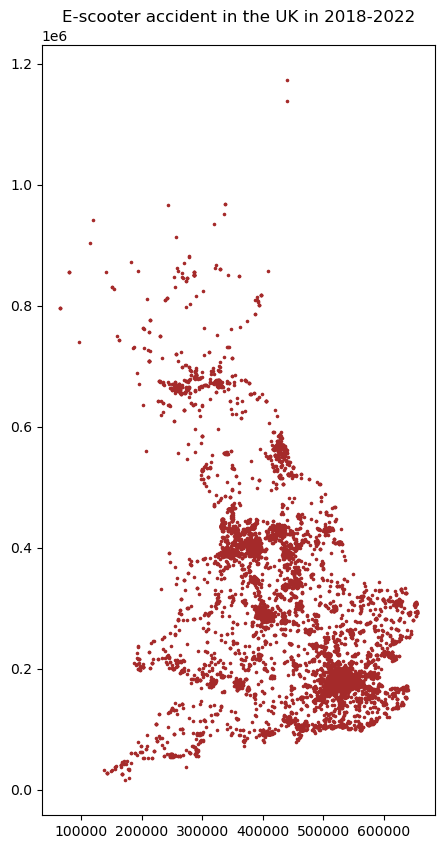

In [77]:
# Plotting the points on a map
fig, ax = plt.subplots(figsize=(10, 10))
escooter_uk_accident_point.plot(ax=ax, color="brown", markersize=2.5)

#ax.axis('off')
plt.title('E-scooter accident in the UK in 2018-2022')
plt.show()

### Spatial subset

In [17]:
# Spatial subset/clip accident points by London ward
escooter_london_accident_point = gpd.clip(escooter_uk_accident_point, london_ward)

# Check how many rows it has within London boundary
escooter_london_accident_point

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location,geometry
366005,2019010228526,2019,90,525839.0,163830.0,31/12/2019,3,17:20,E01004142,POINT (525839.000 163830.000)
33678,2018010126361,2018,90,525950.0,163900.0,10/08/2018,6,11:50,E01004142,POINT (525950.000 163900.000)
15546,2018010103741,2018,90,529290.0,158070.0,24/04/2018,3,14:06,E01001027,POINT (529290.000 158070.000)
839024,2021010303360,2021,90,529377.0,159023.0,23/04/2021,6,18:00,E01001027,POINT (529377.000 159023.000)
639677,2020010270728,2020,90,529794.0,159216.0,27/09/2020,1,19:45,E01001023,POINT (529794.000 159216.000)
...,...,...,...,...,...,...,...,...,...,...
320477,2019010168130,2019,90,526203.0,195618.0,09/03/2019,7,13:53,E01000270,POINT (526203.000 195618.000)
330768,2019010182198,2019,90,525519.0,195752.0,21/05/2019,3,11:43,E01000268,POINT (525519.000 195752.000)
874979,2021010349255,2021,90,525031.0,196093.0,05/12/2021,1,17:30,E01000288,POINT (525031.000 196093.000)
1098315,2022010385125,2022,90,526542.0,196182.0,28/06/2022,3,08:55,E01000171,POINT (526542.000 196182.000)


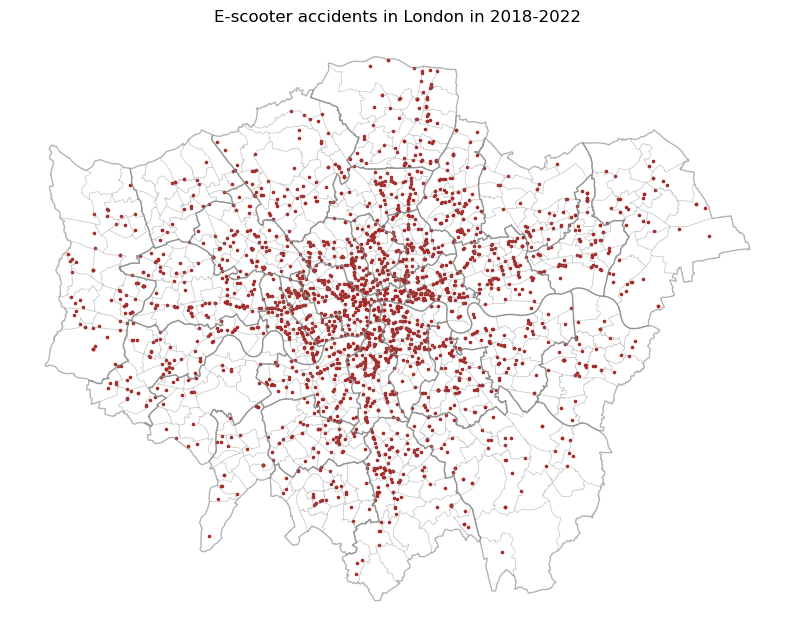

In [79]:
# Plotting the points with London ward
fig, ax = plt.subplots(figsize=(10, 10))

# Plot london borough
london_borough.boundary.plot(ax=ax, color='grey', linewidth=1, alpha=0.5)

# Plot london ward
london_ward.boundary.plot(ax=ax, color="grey", linewidth=0.5, alpha=0.25)

# Plot accident data
escooter_london_accident_point.plot(ax=ax, color="brown", markersize=2.5)

ax.axis('off')
plt.title('E-scooter accidents in London in 2018-2022')
plt.show()

## Spatial join

In this step, a spatial join is performed to integrate ward information from the London ward geodataframe into the e-scooter accident geodataframe. Then the accident occurences are summed by ward and assign it as new column in the London ward. Subsequently, the total accident occurrences are aggregated by ward and added as a new column to the London ward geodataframe.

In [19]:
# Do the spatial join
join = gpd.sjoin(escooter_london_accident_point, london_ward, how='left')

# Check the column list
join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2532 entries, 366005 to 1083528
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   accident_index             2532 non-null   object  
 1   accident_year_x            2532 non-null   int64   
 2   vehicle_type               2532 non-null   int64   
 3   easting                    2532 non-null   float64 
 4   northing                   2532 non-null   float64 
 5   date                       2532 non-null   object  
 6   day_of_week                2532 non-null   int64   
 7   time                       2532 non-null   object  
 8   lsoa_of_accident_location  2532 non-null   object  
 9   geometry                   2532 non-null   geometry
 10  index_right                2532 non-null   int64   
 11  ward                       2532 non-null   object  
 12  gss_code                   2532 non-null   object  
 13  borough               

In [20]:
# Check the join result
join

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location,geometry,index_right,ward,gss_code,borough,lagsscode,hectares,nonld_area
366005,2019010228526,2019,90,525839.0,163830.0,31/12/2019,3,17:20,E01004142,POINT (525839.000 163830.000),381,Sutton Central,E05000564,Sutton,E09000029,131.048,0.0
33678,2018010126361,2018,90,525950.0,163900.0,10/08/2018,6,11:50,E01004142,POINT (525950.000 163900.000),381,Sutton Central,E05000564,Sutton,E09000029,131.048,0.0
15546,2018010103741,2018,90,529290.0,158070.0,24/04/2018,3,14:06,E01001027,POINT (529290.000 158070.000),16,Coulsdon Town,E05011466,Croydon,E09000008,452.138,0.0
839024,2021010303360,2021,90,529377.0,159023.0,23/04/2021,6,18:00,E01001027,POINT (529377.000 159023.000),16,Coulsdon Town,E05011466,Croydon,E09000008,452.138,0.0
639677,2020010270728,2020,90,529794.0,159216.0,27/09/2020,1,19:45,E01001023,POINT (529794.000 159216.000),16,Coulsdon Town,E05011466,Croydon,E09000008,452.138,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320477,2019010168130,2019,90,526203.0,195618.0,09/03/2019,7,13:53,E01000270,POINT (526203.000 195618.000),204,Oakleigh,E05000058,Barnet,E09000003,331.861,0.0
330768,2019010182198,2019,90,525519.0,195752.0,21/05/2019,3,11:43,E01000268,POINT (525519.000 195752.000),204,Oakleigh,E05000058,Barnet,E09000003,331.861,0.0
874979,2021010349255,2021,90,525031.0,196093.0,05/12/2021,1,17:30,E01000288,POINT (525031.000 196093.000),191,Underhill,E05000060,Barnet,E09000003,455.053,0.0
1098315,2022010385125,2022,90,526542.0,196182.0,28/06/2022,3,08:55,E01000171,POINT (526542.000 196182.000),208,East Barnet,E05000048,Barnet,E09000003,374.943,0.0


### Sum accident occurences by ward

In [21]:
# Make new dataframe and count the total accident by ward
escooter_london_accident_by_ward = join.ward.value_counts().rename_axis('ward').reset_index(name='total_accident')

# Show the result
escooter_london_accident_by_ward

,ward,total_accident
0,St. James's,30
1,Castle Baynard,28
2,Old Kent Road,21
3,Lea Bridge,20
4,Camberwell Green,19
...,...,...
534,Childs Hill,1
535,Queens Park,1
536,Tudor,1
537,Lady Margaret,1


Out of 633 wards in London, e-scooter accidents occurred in 539 wards during the period 2018-2022, leaving approximately 94 wards without any recorded accidents.

### Filter to show top wards 

Show only wards that have more then 10 e-scooter accidents

In [22]:
# Show wards with more than 10 accident occurences
ward_with_10_more_accident = escooter_london_accident_by_ward[escooter_london_accident_by_ward['total_accident']>10]

# Show the result
ward_with_10_more_accident

,ward,total_accident
0,St. James's,30
1,Castle Baynard,28
2,Old Kent Road,21
3,Lea Bridge,20
4,Camberwell Green,19
5,Oval,19
6,West End,18
7,Broad Green,17
8,Hoxton East & Shoreditch,17
9,Camden Town with Primrose Hill,16


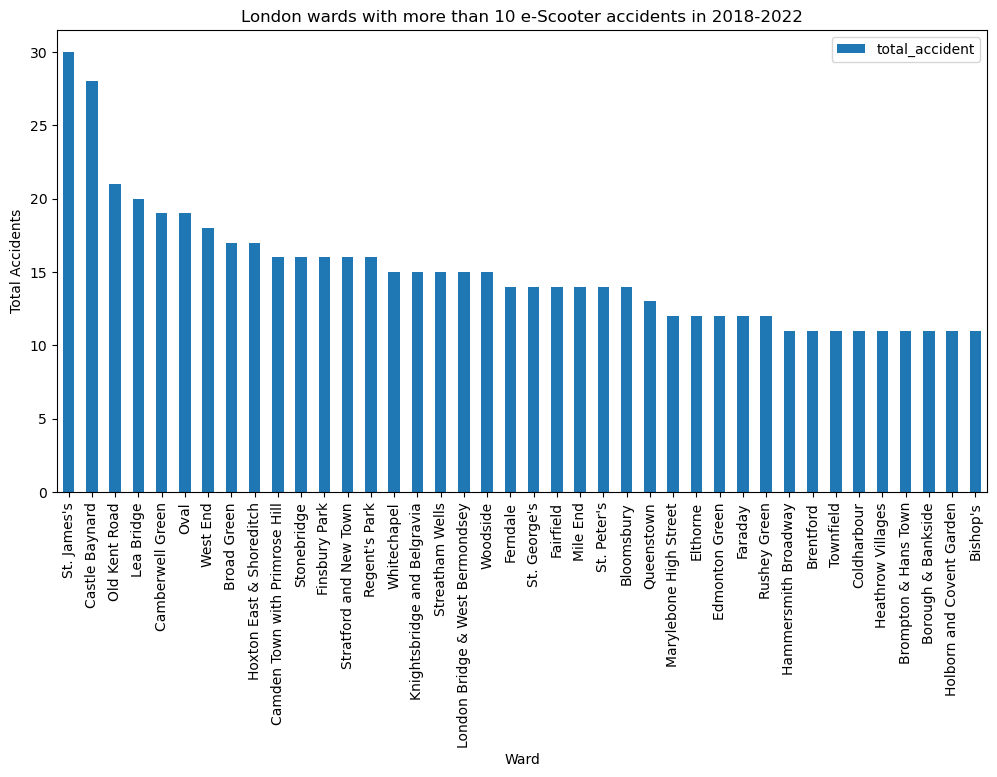

In [23]:
# Make a bar chart of wards with more than 10 accident occurences
# Based on table above, there are 39 wards
ward_with_10_more_accident.plot.bar(figsize=(12,6), x='ward', y='total_accident')

# Add title and labels
plt.title('London wards with more than 10 e-Scooter accidents in 2018-2022')
plt.xlabel('Ward')
plt.ylabel('Total Accidents')

# Show the plot
plt.show()

### Join back to London ward

In [24]:
# Check the London ward gdf
london_ward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ward        633 non-null    object  
 1   gss_code    633 non-null    object  
 2   borough     633 non-null    object  
 3   lagsscode   633 non-null    object  
 4   hectares    633 non-null    float64 
 5   nonld_area  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


In [25]:
# Join the summary table back to the London ward
london_ward = london_ward.merge(escooter_london_accident_by_ward, on='ward', how='left')

# Show the result
london_ward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ward            633 non-null    object  
 1   gss_code        633 non-null    object  
 2   borough         633 non-null    object  
 3   lagsscode       633 non-null    object  
 4   hectares        633 non-null    float64 
 5   nonld_area      633 non-null    float64 
 6   geometry        633 non-null    geometry
 7   total_accident  556 non-null    float64 
dtypes: float64(3), geometry(1), object(4)
memory usage: 39.7+ KB


In [26]:
# Fill NA values with 0
london_ward['total_accident'] = london_ward['total_accident'].fillna(0)

# Show the total accident column in London ward
london_ward

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.000,"POLYGON ((516401.596 160201.802, 516407.302 16...",1.0
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.000,"POLYGON ((519552.998 164295.600, 519508.096 16...",3.0
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.000,"POLYGON ((518107.499 167303.399, 518114.301 16...",0.0
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.000,"POLYGON ((520336.700 165105.498, 520332.198 16...",0.0
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.000,"POLYGON ((521201.203 169275.505, 521204.303 16...",1.0
...,...,...,...,...,...,...,...,...
628,Whalebone,E05000042,Barking and Dagenham,E09000002,155.399,0.000,"POLYGON ((549410.698 187450.702, 549391.199 18...",1.0
629,Eastbrook,E05000030,Barking and Dagenham,E09000002,345.060,0.000,"POLYGON ((549991.497 184928.504, 549988.899 18...",1.0
630,Chadwell Heath,E05000029,Barking and Dagenham,E09000002,338.422,0.000,"POLYGON ((548874.200 188496.303, 548843.199 18...",10.0
631,Parsloes,E05000037,Barking and Dagenham,E09000002,124.384,0.000,"POLYGON ((547381.597 185753.598, 547377.499 18...",3.0


## Normalisation

The data is normalised by adding a new column indicating the total accident occurrences per 100 hectares. This normalised dataset is then visualised through a choropleth map.

In [27]:
# Show statistics of hectares and total accidents
london_ward.describe()

,hectares,nonld_area,total_accident
count,633.000000,633.000000,633.000000
mean,251.926893,3.347156,4.243286
std,257.129524,15.123083,4.080002
min,38.656000,0.000000,0.000000
25%,119.595000,0.000000,1.000000
50%,184.527000,0.000000,3.000000
75%,290.792000,0.000000,6.000000
max,2903.960000,154.284000,30.000000


In [28]:
# Add a new column to show total accident per 100 hectares
london_ward['accident_per_100ha'] = london_ward['total_accident']/london_ward['hectares']*100

In [29]:
# Sort value by accident per 100 hectares
london_ward.sort_values(by='accident_per_100ha').tail()

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha
552,Finsbury Park,E05000371,Islington,E09000019,91.626,0.0,"POLYGON ((530643.900 185815.300, 530619.503 18...",16.0,17.462292
471,Colville,E05009392,Kensington and Chelsea,E09000020,48.988,0.0,"POLYGON ((524368.197 181197.502, 524325.298 18...",9.0,18.371846
562,Lea Bridge,E05009380,Hackney,E09000012,105.971,0.0,"POLYGON ((534756.001 186559.997, 534814.796 18...",20.0,18.873088
239,Camberwell Green,E05011096,Southwark,E09000028,92.752,0.0,"POLYGON ((532543.999 176509.104, 532540.297 17...",19.0,20.484733
253,St. George's,E05011114,Southwark,E09000028,57.296,0.0,"POLYGON ((531231.699 179086.696, 531230.396 17...",14.0,24.434515


In [30]:
# Sort value by accident per 100 hectares
london_ward.sort_values(by='accident_per_100ha').head()

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha
159,Rayners Lane,E05000300,Harrow,E09000015,152.974,0.0,"POLYGON ((512253.399 186150.704, 512246.901 18...",0.0,0.0
364,Wanstead Village,E05011255,Redbridge,E09000026,230.213,0.0,"POLYGON ((540033.104 187596.001, 540027.200 18...",0.0,0.0
161,West Harrow,E05000305,Harrow,E09000015,151.462,0.0,"POLYGON ((513172.302 187844.799, 513214.097 18...",0.0,0.0
52,Farnborough and Crofton,E05000118,Bromley,E09000006,700.584,0.0,"POLYGON ((545344.003 164097.097, 545316.902 16...",0.0,0.0
124,Heaton,E05000314,Havering,E09000016,341.564,0.0,"POLYGON ((553968.403 191390.104, 553952.597 19...",0.0,0.0


### Show top 50 wards

Show top 50 wards accident per 100 hectares.

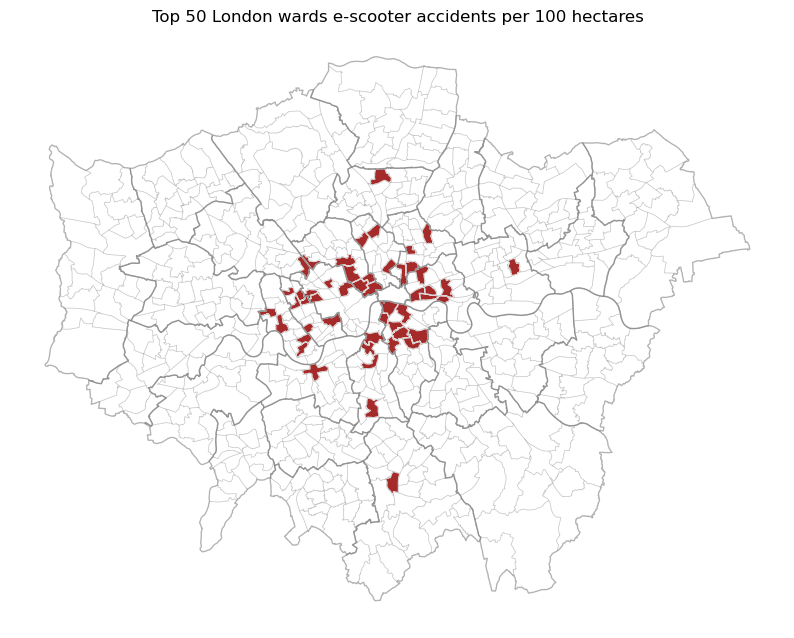

In [80]:
# Map the top 50 wards by accident per 100 hectares
fig, ax = plt.subplots(figsize=(10, 10))

london_borough.boundary.plot(ax=ax, color='grey', linewidth=1, alpha=0.5)
london_ward.boundary.plot(ax=ax, color="grey", linewidth=0.5, alpha=0.25)
london_ward.sort_values(by='accident_per_100ha', ascending=False)[:50].plot(ax=ax,
                                                                            color='brown',
                                                                            edgecolor='white',
                                                                            legend=True
                                                                           )
ax.axis('off')
plt.title('Top 50 London wards e-scooter accidents per 100 hectares')
plt.show()

### Show the regular vs normalised map

Here is shown the regular map by total accident compared to normalised map for total accident per 100 hectares.

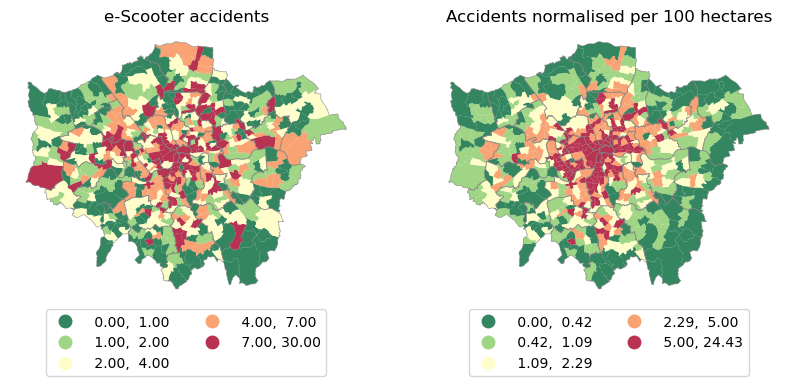

In [32]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#left map: regular count map
london_borough.boundary.plot(ax=ax[0], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[0],
                  column='total_accident',  # this makes it a choropleth
                  alpha=0.8,
                  legend=True,
                  cmap='RdYlGn_r',  # a diverging color scheme
                  scheme='quantiles',  # how to break the data into bins
                  legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2},        
                  k=5)
ax[0].axis('off')
ax[0].set_title("e-Scooter accidents")

# top middle: regular count map (normalized)
london_borough.boundary.plot(ax=ax[1], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[1],
                  column='accident_per_100ha',  # this makes it a choropleth
                  alpha=0.8,
                  legend=True,
                  cmap='RdYlGn_r',  # a diverging color scheme
                  scheme='quantiles',  # how to break the data into bins
                  legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2},        
                  k=5)
ax[1].axis('off')
ax[1].set_title("Accidents normalised per 100 hectares")

plt.show()

# Global Spatial Autocorrelation

After completing the initial steps, which involved loading and wrangling both tabular and spatial data, as well as creating maps based on total accidents and normalized values per 100 hectares, it still need to determine the level of certainty in our findings. To address this, a global spatial autocorrelation analysis is performed to assess whether there is a statistically significant global clustering pattern in the distribution of accidents.

## Calculate spatial weight

Spatial weight quantifies the relationships among geographic locations, revealing how wards are spatially linked or not linked to each other. This approach offers insights into spatial patterns by incorporating the geographical context of the data.

### Using Queen contiguity

In [33]:
# Calculate spatial weights using Queen
wq = Queen.from_dataframe(london_ward, use_index=True)

# Row-standardisation
wq.transform = 'r'

# Explore the spatial weights
print(wq.n)
print(wq.islands)

633
[]


In [34]:
# Get the islands (disconnected components) in the spatial weights
islands_queen = wq.islands

# Identify the wards in the island
island_wards_queen = london_ward.iloc[islands_queen]

# Print information about the island
print("Island Wards:")
print(island_wards_queen[['ward', 'borough']])

Island Wards:
Empty DataFrame
Columns: [ward, borough]
Index: []


### Using Rook contiguity

In [35]:
# Calculate spatial weights using Rook
wr = Rook.from_dataframe(london_ward, use_index=True)

# Row-standardisation
wr.transform = 'r'

# Explore the spatial weights
print(wr.n)
print(wr.islands)

633
[]


In [36]:
# Get the islands (disconnected components) in the spatial weights
islands_rook = wr.islands

# Identify the wards in the island
island_wards_rook = london_ward.iloc[islands_rook]

# Print information about the island
print("Island Wards:")
print(island_wards_rook[['ward', 'borough']])

Island Wards:
Empty DataFrame
Columns: [ward, borough]
Index: []


### Using KNN

In [37]:
# calculate spatial weight using KNN (k=8)
wk = lps.weights.KNN.from_dataframe(london_ward, k=8)

# Row-standardisation
wk.transform = 'r'

# Explore the spatial weights
print(wk.n)
print(wk.islands)

633
[]


In [38]:
# Get the islands (disconnected components) in the spatial weights
islands_knn = wk.islands

# Identify the wards in the island
island_wards_knn = london_ward.iloc[islands_knn]

# Print information about the island
print("Island Wards:")
print(island_wards_knn[['ward', 'borough']])

Island Wards:
Empty DataFrame
Columns: [ward, borough]
Index: []


Based on the results above, none of the calculations have isolated components (islands). As a result, all the findings will be considered for subsequent steps.

## Calculate spatial lag

Spatial lag is defined by calculating the data values from others in their "neighbourhood" as defined by the spatial weight. In simpler term, it represents the average value of surrounding wards calculated using the chosen spatial weight approach.

In [39]:
# Create a new column for the spatial lag using Queen
london_ward['lag_queen'] = lps.weights.lag_spatial(wq, london_ward['accident_per_100ha'])

In [40]:
# Create a new column for the spatial lag using Rook
london_ward['lag_rook'] = lps.weights.lag_spatial(wr, london_ward['accident_per_100ha'])

In [41]:
# Create a new column for the spatial lag
london_ward['lag_knn'] = lps.weights.lag_spatial(wk, london_ward['accident_per_100ha'])

**Compare the results**

In [42]:
# Show 10 row of the result randomly
london_ward.sample(10)

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn
380,Sutton West,E05000567,Sutton,E09000029,178.215,0.000,"POLYGON ((524755.096 165075.197, 524775.898 16...",0.0,0.000000,1.455523,1.455523,1.218954
462,Addison,E05000250,Hammersmith and Fulham,E09000013,55.481,0.000,"POLYGON ((523236.001 179252.499, 523221.102 17...",3.0,5.407257,7.055923,7.055923,6.308359
508,Cantelowes,E05000131,Camden,E09000007,75.933,0.000,"POLYGON ((528967.597 184556.101, 528967.597 18...",4.0,5.267802,8.068712,6.372058,8.045955
261,Sydenham,E05000452,Lewisham,E09000023,174.372,0.000,"POLYGON ((535231.699 171120.097, 535230.603 17...",4.0,2.293946,1.714675,1.714675,1.959685
537,Limehouse,E05009326,Tower Hamlets,E09000030,49.612,10.510,"POLYGON ((536703.303 180460.203, 536697.004 18...",5.0,10.078207,6.100237,6.100237,7.497963
343,Hale End and Highams Park,E05000597,Waltham Forest,E09000031,234.689,0.000,"POLYGON ((538555.003 190068.803, 538551.499 19...",1.0,0.426096,0.853517,0.853517,1.014573
310,Cockfosters,E05000196,Enfield,E09000010,1041.279,0.000,"POLYGON ((527050.604 200169.601, 527156.297 20...",0.0,0.000000,0.345875,0.345875,0.486555
303,Thamesmead East,E05011232,Bexley,E09000004,514.392,85.721,"POLYGON ((547314.103 180114.002, 547308.397 18...",0.0,0.000000,1.024076,1.024076,0.784062
260,Blackheath,E05000438,Lewisham,E09000023,231.823,0.000,"POLYGON ((538102.399 176312.700, 538077.103 17...",3.0,1.294091,1.981189,1.981189,2.375533
48,Biggin Hill,E05000107,Bromley,E09000006,828.039,0.000,"POLYGON ((540373.600 157530.397, 540361.199 15...",1.0,0.120767,0.602809,0.602809,0.503349


In [43]:
# Observe the statistics
london_ward.describe()

,hectares,nonld_area,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,251.926893,3.347156,4.243286,2.999023,3.024589,3.023792,3.131575
std,257.129524,15.123083,4.080002,3.686360,2.738248,2.749647,2.665038
min,38.656000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161223
25%,119.595000,0.000000,1.000000,0.559896,0.955892,0.948421,1.065003
50%,184.527000,0.000000,3.000000,1.679416,2.010895,2.008656,2.125094
75%,290.792000,0.000000,6.000000,3.935226,4.408193,4.357986,4.815836
max,2903.960000,154.284000,30.000000,24.434515,14.185415,14.185415,12.271687


### The donut and the diamond

Donut is the highest negative difference, where a low value surrounded by high values. On the other hand, diamond is the highest positive difference, where a high value surrounded by low values.

**Queen contiguity**

In [44]:
# Create a new column that calculates the difference between accident per 100 hectares and lag queen
london_ward['lag_queen_diff'] = london_ward['accident_per_100ha'] - london_ward['lag_queen']

In [45]:
# Sort the result by that column
london_ward.sort_values(by='lag_queen')

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff
376,Belmont,E05000557,Sutton,E09000029,233.332,0.000,"POLYGON ((525330.997 161651.497, 525328.499 16...",2.0,0.857148,0.000000,0.000000,0.992988,0.857148
47,Chelsfield and Pratts Bottom,E05000110,Bromley,E09000006,1256.320,0.000,"POLYGON ((546001.003 159984.304, 546001.101 15...",0.0,0.000000,0.056482,0.056482,0.381633,-0.056482
123,Havering Park,E05000313,Havering,E09000016,978.330,0.000,"POLYGON ((548106.898 193800.904, 548224.704 19...",2.0,0.204430,0.086934,0.086934,0.786806,0.117496
63,Orpington,E05000122,Bromley,E09000006,425.616,0.000,"POLYGON ((545600.903 165674.096, 545579.499 16...",0.0,0.000000,0.114604,0.114604,0.405576,-0.114604
16,Coulsdon Town,E05011466,Croydon,E09000008,452.138,0.000,"POLYGON ((528552.301 159658.098, 528556.003 15...",3.0,0.663514,0.130793,0.130793,0.385669,0.532722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Borough & Bankside,E05011095,Southwark,E09000028,119.577,18.584,"POLYGON ((532066.800 179335.595, 532063.304 17...",11.0,9.199093,11.253903,11.253903,10.456903,-2.054809
538,Weavers,E05009335,Tower Hamlets,E09000030,67.536,0.000,"POLYGON ((534407.301 182294.298, 534387.001 18...",2.0,2.961384,11.887773,11.887773,9.572502,-8.926390
567,Hoxton West,E05009378,Hackney,E09000012,64.802,0.000,"POLYGON ((532942.697 182547.896, 532854.904 18...",4.0,6.172649,13.449082,13.449082,8.444794,-7.276433
244,Newington,E05011105,Southwark,E09000028,77.889,0.000,"POLYGON ((531775.997 178628.897, 531828.501 17...",1.0,1.283878,13.453814,13.453814,12.271687,-12.169935


In [46]:
# Show the highest negative difference, called donut
queen_donut = london_ward.sort_values(by='lag_queen').head(1)
queen_donut

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff
376,Belmont,E05000557,Sutton,E09000029,233.332,0.0,"POLYGON ((525330.997 161651.497, 525328.499 16...",2.0,0.857148,0.0,0.0,0.992988,0.857148


In [47]:
# Show the highest positive difference, called diamond
queen_diamond = london_ward.sort_values(by='lag_queen').tail(1)
queen_diamond

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff
255,Chaucer,E05011098,Southwark,E09000028,75.06,0.0,"POLYGON ((533016.301 178960.802, 533004.700 17...",3.0,3.996803,14.185415,14.185415,10.028608,-10.188612


**Rook contiguity**

In [48]:
# Create a new column that calculates the difference between accident per 100 hectares and lag rook
london_ward['lag_rook_diff'] = london_ward['accident_per_100ha'] - london_ward['lag_rook']

In [49]:
# Sort the result by that column
london_ward.sort_values(by='lag_rook')

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff
376,Belmont,E05000557,Sutton,E09000029,233.332,0.000,"POLYGON ((525330.997 161651.497, 525328.499 16...",2.0,0.857148,0.000000,0.000000,0.992988,0.857148,0.857148
15,Tudor,E05000415,Kingston upon Thames,E09000021,158.255,0.000,"POLYGON ((519234.302 170410.000, 519164.104 17...",1.0,0.631892,0.339236,0.000000,0.579579,0.292656,0.631892
47,Chelsfield and Pratts Bottom,E05000110,Bromley,E09000006,1256.320,0.000,"POLYGON ((546001.003 159984.304, 546001.101 15...",0.0,0.000000,0.056482,0.056482,0.381633,-0.056482,-0.056482
123,Havering Park,E05000313,Havering,E09000016,978.330,0.000,"POLYGON ((548106.898 193800.904, 548224.704 19...",2.0,0.204430,0.086934,0.086934,0.786806,0.117496,0.117496
63,Orpington,E05000122,Bromley,E09000006,425.616,0.000,"POLYGON ((545600.903 165674.096, 545579.499 16...",0.0,0.000000,0.114604,0.114604,0.405576,-0.114604,-0.114604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Bishop's,E05000416,Lambeth,E09000022,153.959,30.258,"POLYGON ((531313.201 180688.098, 531314.001 18...",11.0,7.144759,10.651997,11.612035,9.941120,-3.507237,-4.467276
538,Weavers,E05009335,Tower Hamlets,E09000030,67.536,0.000,"POLYGON ((534407.301 182294.298, 534387.001 18...",2.0,2.961384,11.887773,11.887773,9.572502,-8.926390,-8.926390
567,Hoxton West,E05009378,Hackney,E09000012,64.802,0.000,"POLYGON ((532942.697 182547.896, 532854.904 18...",4.0,6.172649,13.449082,13.449082,8.444794,-7.276433,-7.276433
244,Newington,E05011105,Southwark,E09000028,77.889,0.000,"POLYGON ((531775.997 178628.897, 531828.501 17...",1.0,1.283878,13.453814,13.453814,12.271687,-12.169935,-12.169935


In [50]:
# Show the highest negative difference, called donut
rook_donut = london_ward.sort_values(by='lag_rook').head(1)
rook_donut

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff
376,Belmont,E05000557,Sutton,E09000029,233.332,0.0,"POLYGON ((525330.997 161651.497, 525328.499 16...",2.0,0.857148,0.0,0.0,0.992988,0.857148,0.857148


In [51]:
# Show the highest positive difference, called diamond
rook_diamond = london_ward.sort_values(by='lag_rook').tail(1)
rook_diamond

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff
255,Chaucer,E05011098,Southwark,E09000028,75.06,0.0,"POLYGON ((533016.301 178960.802, 533004.700 17...",3.0,3.996803,14.185415,14.185415,10.028608,-10.188612,-10.188612


**KNN**

In [52]:
# Create a new column that calculates the difference between accident per 100 hectares and lag knn
london_ward['lag_knn_diff'] = london_ward['accident_per_100ha'] - london_ward['lag_knn']

In [53]:
# Sort the result by that column
london_ward.sort_values(by='lag_knn')

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff,lag_knn_diff
152,Pinner South,E05000298,Harrow,E09000015,234.561,0.000,"POLYGON ((511772.002 187717.996, 511756.897 18...",0.0,0.000000,0.222771,0.214964,0.161223,-0.222771,-0.214964,-0.161223
151,Pinner,E05000297,Harrow,E09000015,327.742,0.000,"POLYGON ((511851.897 192010.297, 511896.000 19...",0.0,0.000000,0.151359,0.151359,0.191673,-0.151359,-0.151359,-0.191673
64,Cray Valley West,E05000115,Bromley,E09000006,393.850,0.000,"POLYGON ((547448.003 170380.298, 547448.703 17...",4.0,1.015615,0.350478,0.350478,0.252255,0.665137,0.665137,0.763360
192,High Barnet,E05000056,Barnet,E09000003,830.666,0.000,"POLYGON ((520807.600 195272.403, 520810.098 19...",1.0,0.120385,0.347614,0.347614,0.257417,-0.227228,-0.227228,-0.137031
65,Cray Valley East,E05000114,Bromley,E09000006,1327.866,0.000,"POLYGON ((545567.197 167057.000, 545585.699 16...",3.0,0.225926,0.333342,0.333342,0.273950,-0.107416,-0.107416,-0.048024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Vassall,E05000436,Lambeth,E09000022,112.973,0.000,"POLYGON ((532101.701 176563.699, 532100.201 17...",6.0,5.311004,10.696991,10.696991,10.199534,-5.385987,-5.385987,-4.888531
525,Spitalfields & Banglatown,E05009333,Tower Hamlets,E09000030,90.895,0.000,"POLYGON ((533574.096 182138.803, 533614.703 18...",8.0,8.801364,10.597966,10.050264,10.247624,-1.796602,-1.248900,-1.446260
248,Borough & Bankside,E05011095,Southwark,E09000028,119.577,18.584,"POLYGON ((532066.800 179335.595, 532063.304 17...",11.0,9.199093,11.253903,11.253903,10.456903,-2.054809,-2.054809,-1.257809
254,North Walworth,E05011107,Southwark,E09000028,79.610,0.000,"POLYGON ((531876.001 178747.004, 531894.404 17...",9.0,11.305112,9.429450,9.429450,11.121516,1.875662,1.875662,0.183597


In [54]:
# Show the highest negative difference, called donut
knn_donut = london_ward.sort_values(by='lag_knn').head(1)
knn_donut

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff,lag_knn_diff
152,Pinner South,E05000298,Harrow,E09000015,234.561,0.0,"POLYGON ((511772.002 187717.996, 511756.897 18...",0.0,0.0,0.222771,0.214964,0.161223,-0.222771,-0.214964,-0.161223


In [55]:
# Show the highest positive difference, called diamond
knn_diamond = london_ward.sort_values(by='lag_knn').tail(1)
knn_diamond

,ward,gss_code,borough,lagsscode,hectares,nonld_area,geometry,total_accident,accident_per_100ha,lag_queen,lag_rook,lag_knn,lag_queen_diff,lag_rook_diff,lag_knn_diff
244,Newington,E05011105,Southwark,E09000028,77.889,0.0,"POLYGON ((531775.997 178628.897, 531828.501 17...",1.0,1.283878,13.453814,13.453814,12.271687,-12.169935,-12.169935,-10.987809


**The donut and the diamond map**

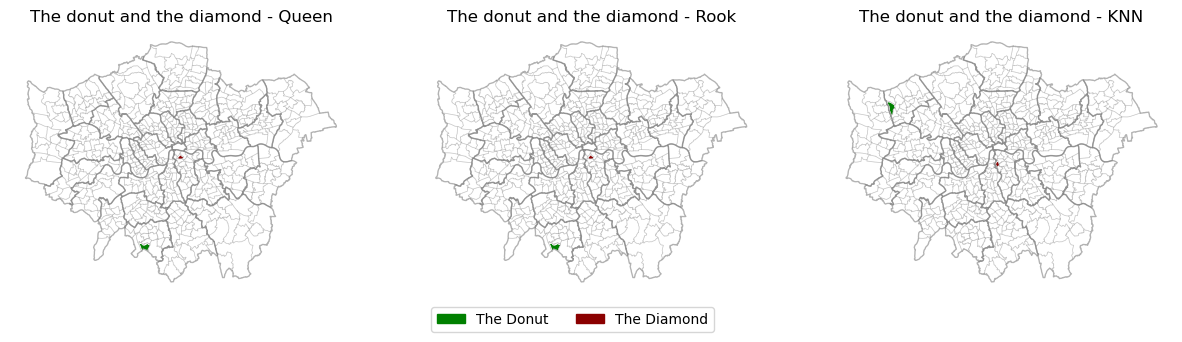

In [56]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Plot the queen donut and diamond
london_borough.boundary.plot(ax=ax[0], color='grey', linewidth=1, alpha=0.5)
london_ward.boundary.plot(ax=ax[0], color="grey", linewidth=0.5, alpha=0.25)
queen_donut.plot(ax=ax[0], color='green', edgecolor='white')
queen_diamond.plot(ax=ax[0], color='darkred', edgecolor='white')
ax[0].axis('off')
ax[0].set_title('The donut and the diamond - Queen')

# Plot the rook donut and diamond
london_borough.boundary.plot(ax=ax[1], color='grey', linewidth=1, alpha=0.5)
london_ward.boundary.plot(ax=ax[1], color="grey", linewidth=0.5, alpha=0.25)
rook_donut.plot(ax=ax[1], color='green', edgecolor='white')
rook_diamond.plot(ax=ax[1], color='darkred', edgecolor='white')
ax[1].axis('off')
ax[1].set_title('The donut and the diamond - Rook')

# Plot the knn donut and diamond
london_borough.boundary.plot(ax=ax[2], color='grey', linewidth=1, alpha=0.5)
london_ward.boundary.plot(ax=ax[2], color="grey", linewidth=0.5, alpha=0.25)
knn_donut.plot(ax=ax[2], color='green', edgecolor='white')
knn_diamond.plot(ax=ax[2], color='darkred', edgecolor='white')
ax[2].axis('off')
ax[2].set_title('The donut and the diamond - KNN')

# Create a common legend
donut_patch = mpatches.Patch(color='green', label='The Donut')
diamond_patch = mpatches.Patch(color='darkred', label='The Diamond')
legend = fig.legend(handles=[donut_patch, diamond_patch], loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2)

plt.show()

### Spatial lag map

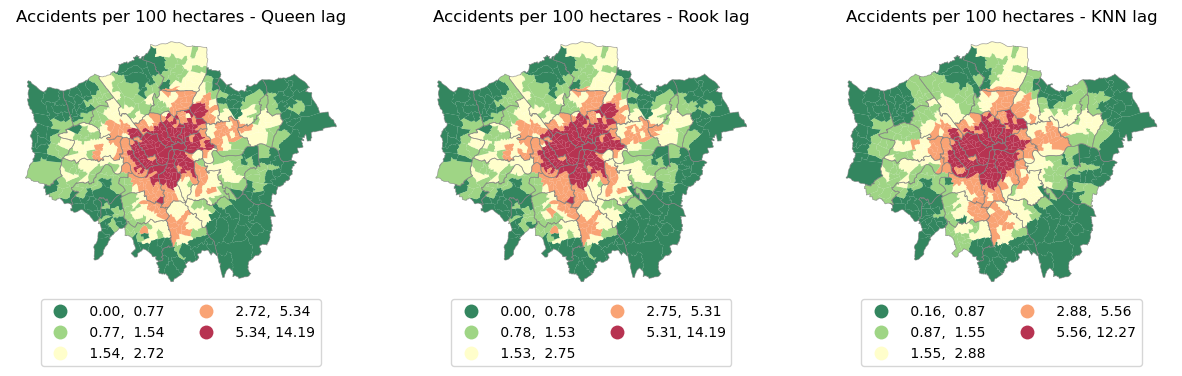

In [57]:
#Show all the accident per 100 hectares in choropleth
fig,ax = plt.subplots(1,3,figsize=(15,5))

# queen
london_borough.boundary.plot(ax=ax[0], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[0],
        column='lag_queen', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}        
                ) 
ax[0].axis('off')
ax[0].set_title('Accidents per 100 hectares - Queen lag')

# rook
london_borough.boundary.plot(ax=ax[1], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[1],
        column='lag_rook', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}        
                ) 
ax[1].axis('off')
ax[1].set_title('Accidents per 100 hectares - Rook lag')

# knn
london_borough.boundary.plot(ax=ax[2], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[2],
        column='lag_knn', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}         
                ) 
ax[2].axis('off')
ax[2].set_title('Accidents per 100 hectares - KNN lag')

plt.show()

### Spatial lag difference map

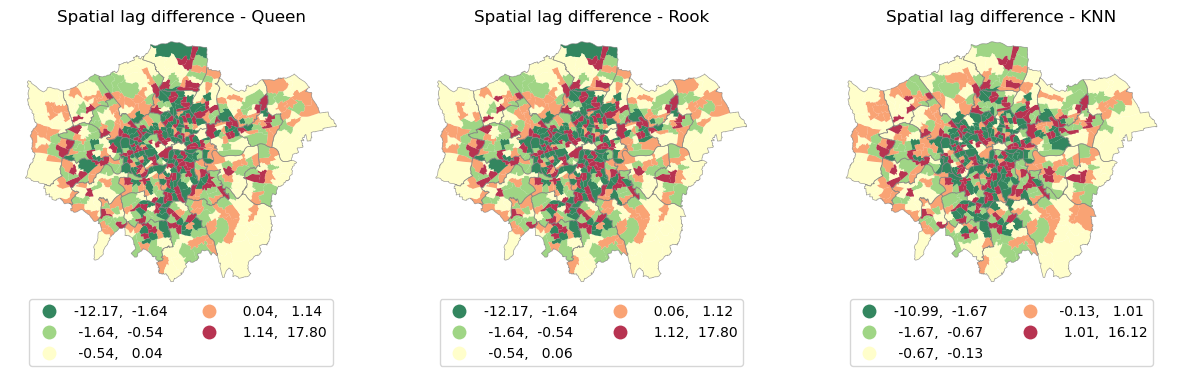

In [58]:
#Show all spatial lag difference in choropleth
fig,ax = plt.subplots(1,3,figsize=(15,5))

# lag queen difference
london_borough.boundary.plot(ax=ax[0], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[0],
        column='lag_queen_diff', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}        
                ) 
ax[0].axis('off')
ax[0].set_title('Spatial lag difference - Queen')

# lag rook difference
london_borough.boundary.plot(ax=ax[1], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[1],
        column='lag_rook_diff', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}        
                ) 
ax[1].axis('off')
ax[1].set_title('Spatial lag difference - Rook')

# lag knn difference
london_borough.boundary.plot(ax=ax[2], color='grey', linewidth=0.5, alpha=0.75)
london_ward.plot(ax=ax[2],
        column='lag_knn_diff', # this makes it a choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', # a diverging color scheme
        scheme='quantiles', # how to break the data into bins
        legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 2}         
                ) 
ax[2].axis('off')
ax[2].set_title('Spatial lag difference - KNN')

plt.show()

## Moran's I plot

**Using Queen contiguity**

In [59]:
# Calculate Moran's I using queen
y = london_ward.accident_per_100ha

queen_moran = Moran(y,wq)
queen_moran.I

0.47670294486646064

**Using Rook contiguity**

In [60]:
# Calculate Moran's I using rook
y = london_ward.accident_per_100ha

rook_moran = Moran(y,wr)
rook_moran.I

0.47856345246894594

**Using KNN**

In [61]:
# Calculate Moran's I using knn
y = london_ward.accident_per_100ha

knn_moran = Moran(y,wk)
knn_moran.I

0.47162430645000086

**Show the scatterplots**

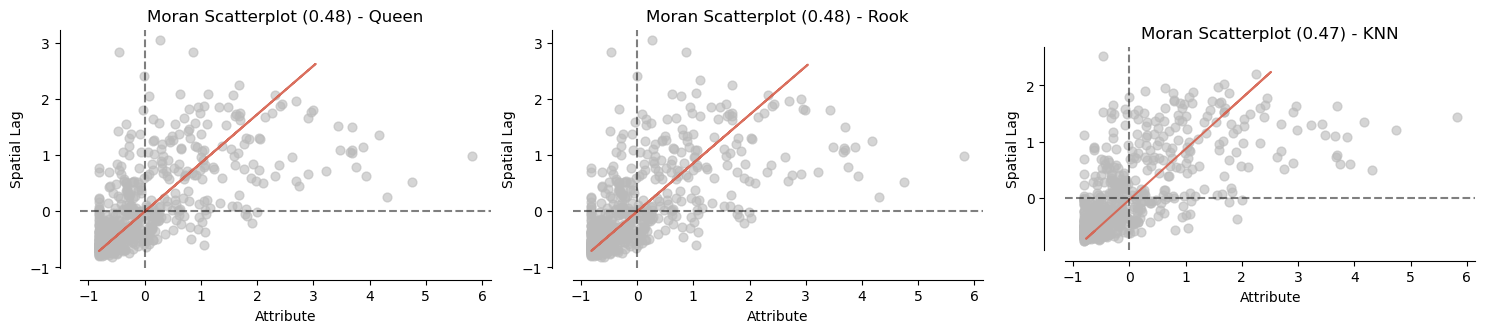

In [62]:
# Create a 1x3 subplot for Moran Scatterplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Moran Scatterplot for Queen
moran_scatterplot(queen_moran, ax=ax[0], aspect_equal=True)
ax[0].set_title(f'Moran Scatterplot ({round(queen_moran.I, 2)}) - Queen')

# Moran Scatterplot for Rook
moran_scatterplot(rook_moran, ax=ax[1], aspect_equal=True)
ax[1].set_title(f'Moran Scatterplot ({round(rook_moran.I, 2)}) - Rook')

# Moran Scatterplot for KNN
moran_scatterplot(knn_moran, ax=ax[2], aspect_equal=True)
ax[2].set_title(f'Moran Scatterplot ({round(knn_moran.I, 2)}) - KNN')

plt.show()


C:\Users\fajrunwm\anaconda3\envs\envGEOG0115\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
C:\Users\fajrunwm\anaconda3\envs\envGEOG0115\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
C:\Users\fajrunwm\anaconda3\envs\envGEOG0115\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


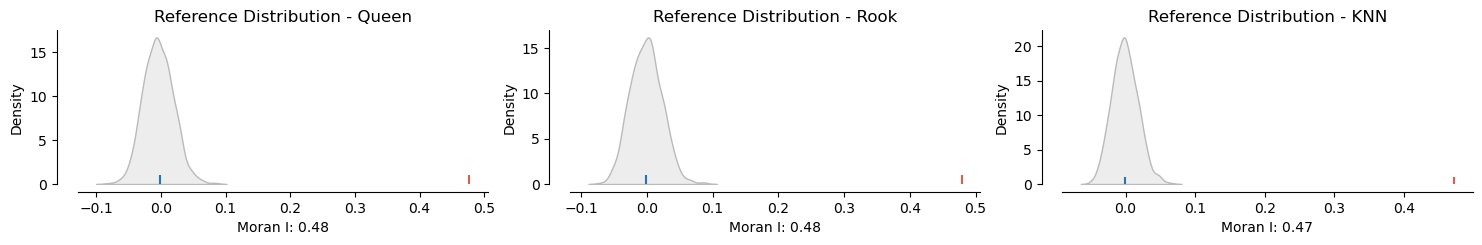

In [63]:
# Create a 1x3 subplot for Moran Simulation plots
fig, ax = plt.subplots(1, 3, figsize=(18, 2))

# Moran Simulation for Queen
plot_moran_simulation(queen_moran, ax=ax[0], aspect_equal=False, fill=True)
ax[0].set_title(f'Reference Distribution - Queen')

# Moran Simulation for Rook
plot_moran_simulation(rook_moran, ax=ax[1], aspect_equal=False, fill=True)
ax[1].set_title(f'Reference Distribution - Rook')

# Moran Simulation for KNN
plot_moran_simulation(knn_moran, ax=ax[2], aspect_equal=False, fill=True)
ax[2].set_title(f'Reference Distribution - KNN')

plt.show()

In [64]:
# Calculate the p-value - queen
queen_moran.p_sim

0.001

In [65]:
# Calculate the p-value - rook
rook_moran.p_sim

0.001

In [66]:
# Calculate the p-value - knn
knn_moran.p_sim

0.001

# Local Spatial Autocorrelation

## Local Moran's scatterplot

In [67]:
# Calculate local moran values - queen
queen_lisa = esda.moran.Moran_Local(y,wq)

In [68]:
# Calculate local moran values - rook
rook_lisa = esda.moran.Moran_Local(y,wr)

In [69]:
# Calculate local moran values - knn
knn_lisa = esda.moran.Moran_Local(y,wk)

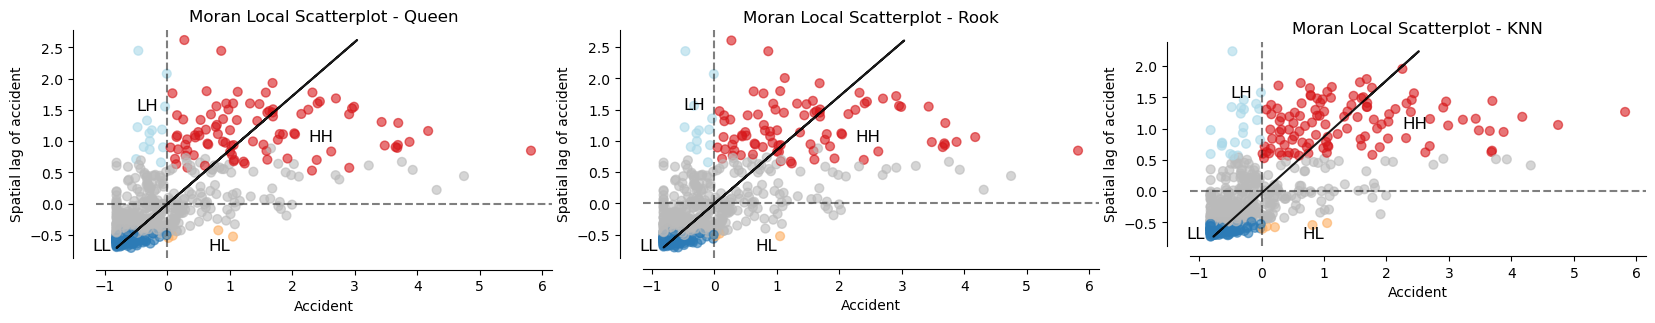

In [70]:
# Create a 1x3 subplot for Moran Local Scatterplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Queen Moran Local Scatterplot
moran_scatterplot(queen_lisa, ax=ax[0], p=0.05)
ax[0].set_title('Moran Local Scatterplot - Queen')
ax[0].set_xlabel('Accident')
ax[0].set_ylabel('Spatial lag of accident')
ax[0].text(2.25, 1, 'HH', fontsize=12)
ax[0].text(0.65, -0.75, 'HL', fontsize=12)
ax[0].text(-0.5, 1.5, 'LH', fontsize=12)
ax[0].text(-1.2, -0.75, 'LL', fontsize=12)

# Rook Moran Local Scatterplot
moran_scatterplot(rook_lisa, ax=ax[1], p=0.05)
ax[1].set_title('Moran Local Scatterplot - Rook')
ax[1].set_xlabel('Accident')
ax[1].set_ylabel('Spatial lag of accident')
ax[1].text(2.25, 1, 'HH', fontsize=12)
ax[1].text(0.65, -0.75, 'HL', fontsize=12)
ax[1].text(-0.5, 1.5, 'LH', fontsize=12)
ax[1].text(-1.2, -0.75, 'LL', fontsize=12)

# KNN Moran Local Scatterplot
moran_scatterplot(knn_lisa, ax=ax[2], p=0.05)
ax[2].set_title('Moran Local Scatterplot - KNN')
ax[2].set_xlabel('Accident')
ax[2].set_ylabel('Spatial lag of accident')
ax[2].text(2.25, 1, 'HH', fontsize=12)
ax[2].text(0.65, -0.75, 'HL', fontsize=12)
ax[2].text(-0.5, 1.5, 'LH', fontsize=12)
ax[2].text(-1.2, -0.75, 'LL', fontsize=12)

plt.show()

## Spatial autocorrelation map

In [71]:
# Final step, visualise the statistically significant cluster using the lisa_cluster function
# As lisa_cluster can only show in Mercator projection, so make gdf using CRS EPSG:3857
london_borough_mercator = london_borough.to_crs(epsg=3857)
london_ward_mercator = london_ward.to_crs(epsg=3857)

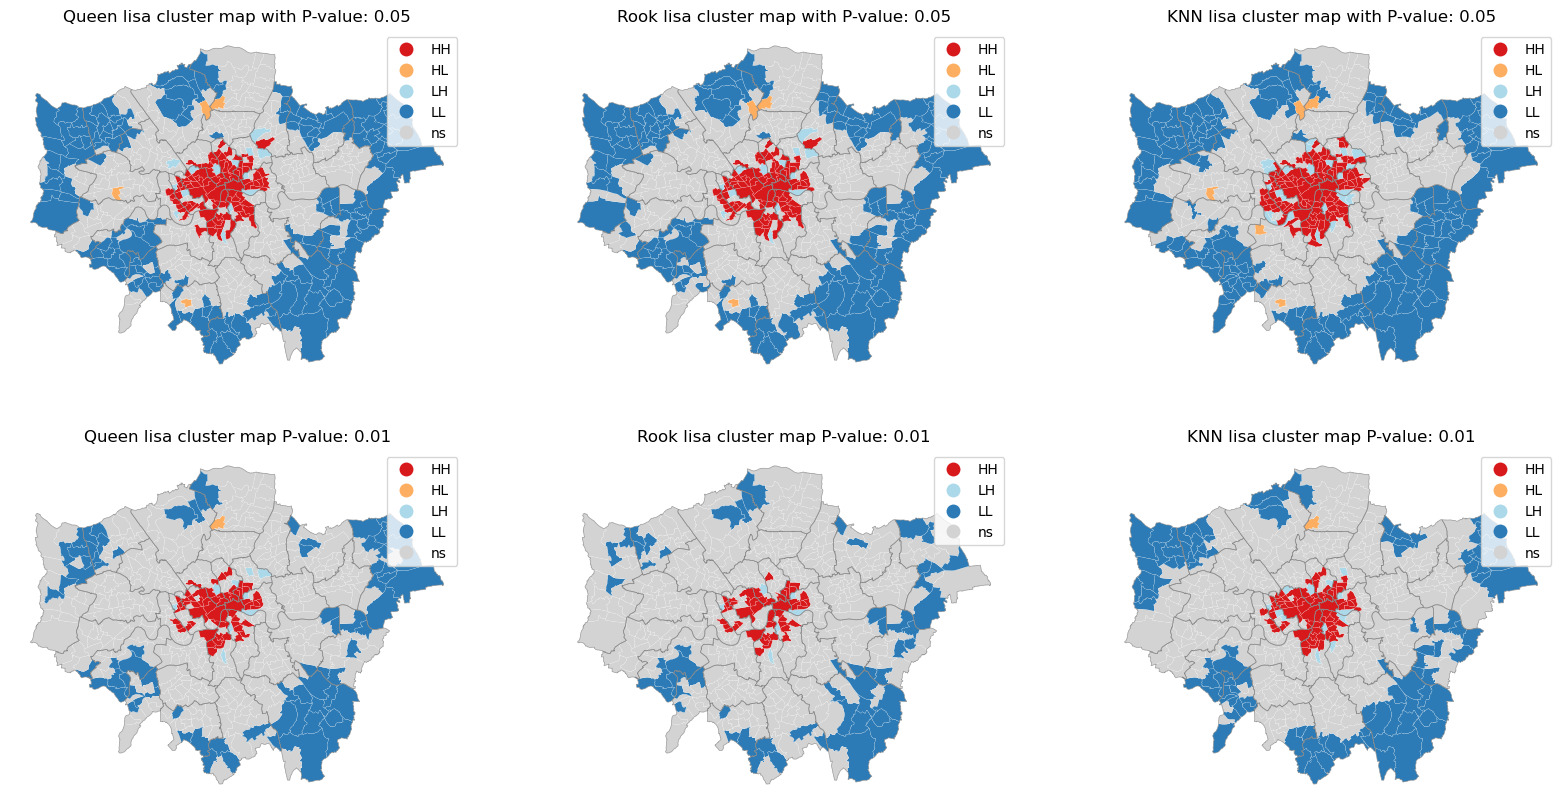

In [76]:
# Create a 2x3 subplot for lisa_cluster maps
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Queen lisa_cluster map p-0.05
london_borough_mercator.boundary.plot(ax=ax[0,0], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(queen_lisa, london_ward_mercator, p=0.05, ax=ax[0,0])
ax[0,0].set_title('Queen lisa cluster map with P-value: 0.05')
ax[0,0].axis('off')

# Rook lisa_cluster map p-0.05
london_borough_mercator.boundary.plot(ax=ax[0,1], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(rook_lisa, london_ward_mercator, p=0.05, ax=ax[0,1])
ax[0,1].set_title('Rook lisa cluster map with P-value: 0.05')
ax[0,1].axis('off')

# KNN lisa_cluster map p-0.05
london_borough_mercator.boundary.plot(ax=ax[0,2], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(knn_lisa, london_ward_mercator, p=0.05, ax=ax[0,2])
ax[0,2].set_title('KNN lisa cluster map with P-value: 0.05')
ax[0,2].axis('off')

# Queen lisa_cluster map p-0.01
london_borough_mercator.boundary.plot(ax=ax[1,0], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(queen_lisa, london_ward_mercator, p=0.01, ax=ax[1,0])
ax[1,0].set_title('Queen lisa cluster map P-value: 0.01')
ax[1,0].axis('off')

# Rook lisa_cluster map p-0.01
london_borough_mercator.boundary.plot(ax=ax[1,1], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(rook_lisa, london_ward_mercator, p=0.01, ax=ax[1,1])
ax[1,1].set_title('Rook lisa cluster map P-value: 0.01')
ax[1,1].axis('off')

# KNN lisa_cluster map p-0.01
london_borough_mercator.boundary.plot(ax=ax[1,2], color='grey', linewidth=0.5, alpha=0.75)
lisa_cluster(knn_lisa, london_ward_mercator, p=0.01, ax=ax[1,2])
ax[1,2].set_title('KNN lisa cluster map P-value: 0.01')
ax[1,2].axis('off')

plt.show()

***

###